In [1]:
!pip install fastbook
from fastbook import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 10.5 MB/s eta 0:00:00


In [2]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 15.0.2 which is incompatible.


In [3]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    with DDGS() as ddgs:
        search_results = ddgs.images(keywords=term)       
        image_urls = [result.get("image") for result in search_results[:max_images]]
        return image_urls

In [4]:
from fastbook import *

In [5]:
urls = search_images_ddg('bird photos', max_images=1)
len(urls), urls[0]

(1,
 'https://www.worldatlas.com/r/w1200/upload/58/1b/eb/shutterstock-760749433.jpg')

In [6]:
dest = Path('bird.jpg')
if not dest.exists(): download_url(urls[0], dest, show_progress=True)

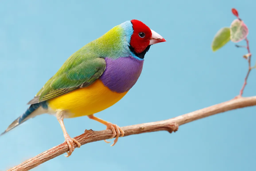

In [7]:
im = Image.open(dest)
im.to_thumb(256, 256)

In [8]:
urls = search_images("forest images", max_images=1)

Searching for 'forest images'


In [9]:
urls[0]

'https://wallpapercave.com/wp/GD9rMAh.jpg'

In [10]:
searches = 'forest', 'birds'
path = Path('birds_or_not')
# path.mkdir(exist_ok=True)
if not path.exists():
    path.mkdir(exist_ok=True)
    for o in searches:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} photo')
        download_images(dest, urls=results[:200])
        resize_images(dest, max_size=400, dest=dest)

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [11]:
#deletes images that dont work
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)

(#4) [None,None,None,None]

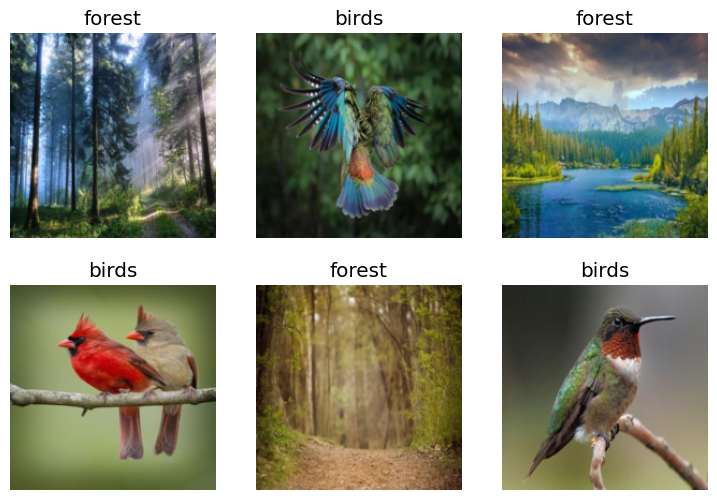

In [12]:
dls = DataBlock(
                #what kind of inputs and outputs are there
                blocks = (ImageBlock, CategoryBlock),
                #get_image_files is a function that returns a list of all image files
                get_items = get_image_files,
                #create a validation set(here 20% of the data is kept aside for validation)
                splitter = RandomSplitter(valid_pct=0.2, seed=42),
                #parent_label is a function returns parent folder of a path here 'forest' or 'bird'
                get_y = parent_label,
                #item transforms - resize each image
                item_tfms = [Resize(192, method='squish')]
).dataloaders(path) #dataloader feeds the training algorithm with a batch of images

#shows image and label
dls.show_batch(max_n=6)

In [13]:
#learner combines the model(resnet18) and the data(dls) 
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 119MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.966909,0.674553,0.256757,00:22


epoch,train_loss,valid_loss,error_rate,time
0,0.080309,0.086362,0.040541,00:29
1,0.044415,0.010485,0.000000,00:30
2,0.030756,0.006181,0.000000,00:30


The above code runs through every photo out of 400, for all the forests it will learn a bit about what a forest looks like and for all the birds it will learn a bit about what a bird looks like

In [14]:
"""deploy your project - return a string whether its a bird or not, 
an integer whether its a bird or not and probability of it being a bird"""
is_bird, _, probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a : {is_bird} ")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a : birds 
Probability it's a bird: 0.9998
